# Simple task mixing

I'm hoping now with my cleaner code, I can now more efficiently examine other tasks with this backprop method.

This first task I _think_ will involve a very trivial task mixing. There will be three inputs:
- $x_1$ - one number to multiply with...
- $x_2$ - another number
- $g$ - a gate

The logic is follows (in pseudo code):
```python
if g == 1:
    return x1 * x2
if g == 0:
    return 0
```
This way, we'll hopefully see that `g` _has_ to mix into the output at some point.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [3]:
# seed = np.random.randint(1, 2**32 - 1)
seed = 2052234806  # this one is very interesting
set_all_seeds(seed)
print(seed)

2052234806


## Model

Keeping this extremely simple

In [4]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(
        self, input_dim=3, hidden_dim=16, output_dim=1, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

In [5]:
import torch

# Number of samples
n_samples = 10000

# Epsilon value
eps = 0.5


# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


# Initial generation
Y = generate_Y(n_samples)
X = generate_X(Y, eps)
G = np.random.choice([0, 1], n_samples, p=[0.5, 0.5])
G = torch.as_tensor(G)
X = torch.cat((X, G[:, None]), dim=1)
Y = Y * G

Y = Y[:, None]

# Validate the relationship
assert torch.allclose(X[:, 0] * X[:, 1] * G, Y[:, 0])

# Print the shapes
print(X.shape, Y.shape)

torch.Size([10000, 3]) torch.Size([10000, 1])


In [6]:
X[:10]

tensor([[0.8721, 0.2535, 0.0000],
        [0.5080, 1.5711, 1.0000],
        [0.8500, 0.9101, 1.0000],
        [0.6694, 0.4112, 0.0000],
        [1.1426, 0.7231, 1.0000],
        [0.8262, 0.1282, 1.0000],
        [0.5378, 0.1927, 1.0000],
        [0.5445, 0.6221, 0.0000],
        [0.1007, 0.8030, 1.0000],
        [0.9025, 0.7349, 0.0000]])

In [7]:
Y[:10]

tensor([[0.0000],
        [0.7982],
        [0.7736],
        [0.0000],
        [0.8262],
        [0.1060],
        [0.1036],
        [0.0000],
        [0.0809],
        [0.0000]])

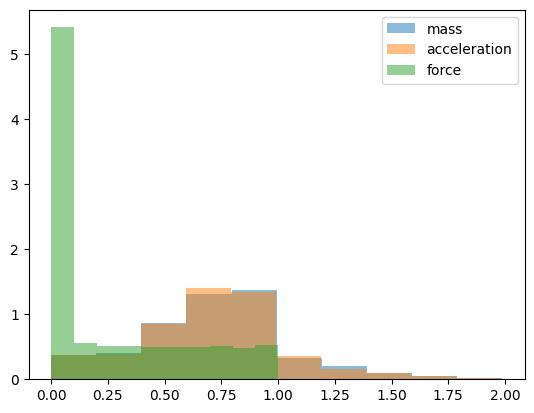

In [8]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

In [9]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 3]),
 torch.Size([8000, 1]),
 torch.Size([2000, 3]),
 torch.Size([2000, 1]))

## Training

I'll just do full gradient descent to keep things simple.

In [10]:
N = 1000  # number of epochs
hidden_dim = 16  # number of hidden units

model = Net(input_dim=3, hidden_dim=hidden_dim, output_dim=1)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Results

In [11]:
from physics_mi.eval import *


# need to avoid flattening here because we have multiple outputs
def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = Y_valid.numpy()

    return y_preds, y_targs

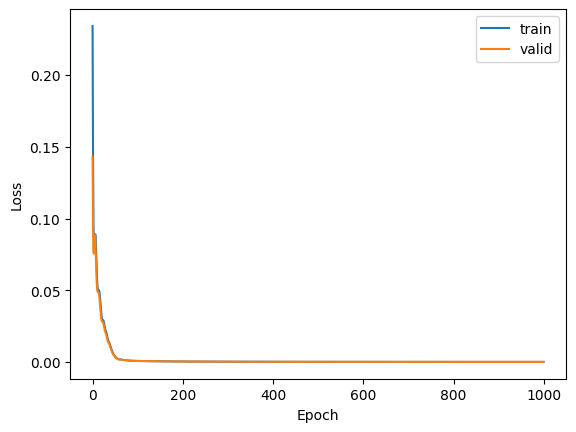

In [12]:
plot_loss(df["train_loss"], df["valid_loss"])

In [13]:
y_preds, y_targs = get_preds(model, X_valid, Y_valid)
y_preds.shape, y_targs.shape

((2000, 1), (2000, 1))

In [14]:
get_valid_loss(model, loss_func, X_valid, Y_valid)

tensor(4.4441e-05)

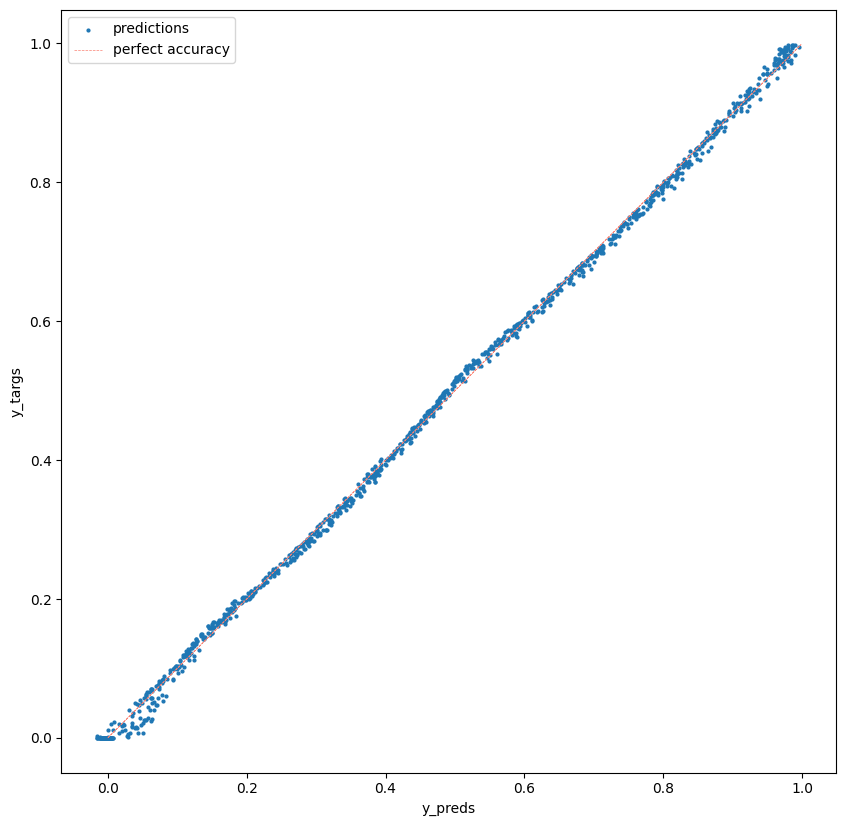

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_results(y_preds, y_targs, ax=ax)

## Introspection

In [16]:
from physics_mi.analysis import capture_intermediate_outputs

In [17]:
valid_ios = capture_intermediate_outputs(model, X_valid)
valid_ios["input"] = X_valid

In [18]:
class ScaffoldNet(Net):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.requires_grad_(False)

    def forward(self, lidx, linputs):
        sub_net = self.layers[lidx : lidx + 1]
        out = sub_net(linputs)
        return out


scaffold_model = ScaffoldNet()
scaffold_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [19]:
ios = valid_ios
layer_keys = [
    "input",
    "layers.0.act",
    "layers.1.act",
    "layers.2.linear.bias",
]  # these are where from we would like to extract the components

In [20]:
from physics_mi.graph import (
    generate_graph,
    add_plot_coords,
    nx_graph_from_pandas,
    plot_nx_graph,
)

In [21]:
ndf, edf = generate_graph(ios, layer_keys, scaffold_model)
ndf = add_plot_coords(ndf, layer_keys)
G = nx_graph_from_pandas(ndf, edf)

In [22]:
from physics_mi.analysis import plot_similarity_matrix, get_sims

input


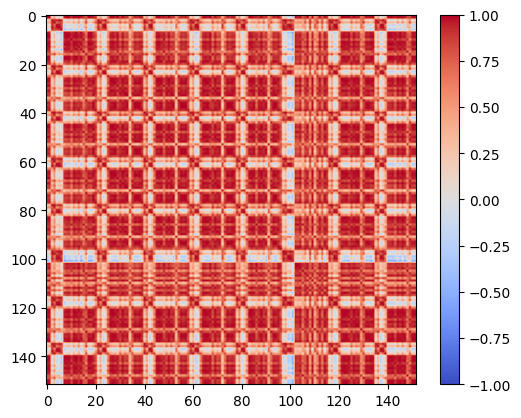

In [31]:
lk = layer_keys[0]
print(lk)
plot_similarity_matrix(get_sims(ndf, lk))

layers.0.act


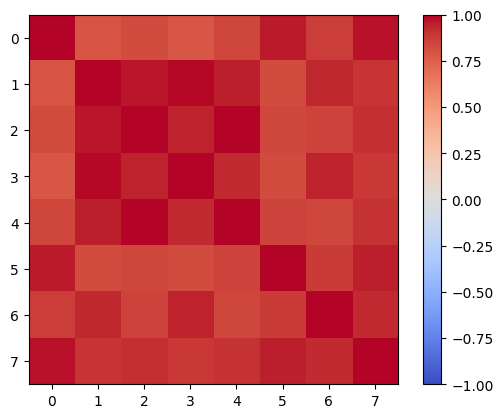

In [32]:
lk = layer_keys[1]
print(lk)
plot_similarity_matrix(get_sims(ndf, lk))

layers.1.act


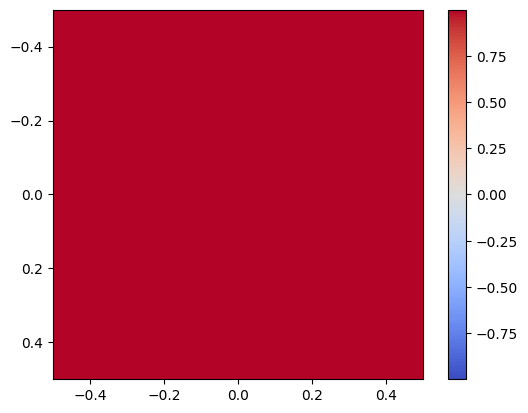

In [33]:
lk = layer_keys[2]
print(lk)
plot_similarity_matrix(get_sims(ndf, lk))

Some structure here where you can see there is some task independence in the first layer but not the second. We might (very very tentatively) hypothesise that the second layer is doing the job of mixing the multiplication with the gate but I realise now that I've picked a commutative operation i.e. the gate can be multiplied with either answer first (or both at the same time). Let's try and think of something non-commutative i.e. input 3 _needs_ to be mixed in afterwards in order to get the right answer 🤔 